In [1]:
### TODO:
#   - najdi primerni podatkovni bazi za regresijo in klasifikacijo
#   - omogoči naključno rezanje uteži
#   - ustvari lažje podajanje hiperparametrov
#   - !!ročno inicializiraj uteži z Gaussian Glorot initialization ALI Gaussian z standard deviation 0.1
#   - !!ustvari lepši ui, ki na boljši način prikaže rezanje in učenje.
#   - podatke kot je early stopping rate, natančnost itd. itd. je treba nekje shraniti in prikazati
#   - !!sproti shranjuj nekatere modele npr. najbolj natančnega, najbolj rezanega ali po vsakem rezanju

In [2]:
import torch
import numpy as np
import torchvision.transforms as transforms
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchinfo
import matplotlib
from matplotlib import pyplot as plt
from torch.utils.tensorboard import SummaryWriter

from neural_network import *
from iterative_pruning import IterativePruning

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [4]:
NUM_CHANNELS = 10
BATCH_SIZE = 128
NUM_EPOCHS = 100
IMAGE_SIZE = [28, 28]
LR = 1.2e-3

In [5]:
transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor(),
])

##pin_memory in num_workers=6

mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

train_subset, val_subset = torch.utils.data.random_split(mnist_trainset, [50000, 10000], generator=torch.Generator().manual_seed(1))

X_train = train_subset.dataset.data[train_subset.indices]
y_train = train_subset.dataset.targets[train_subset.indices]

X_val = val_subset.dataset.data[val_subset.indices]
y_val = val_subset.dataset.targets[val_subset.indices]

train_loader = DataLoader(dataset=train_subset, shuffle=True, batch_size=BATCH_SIZE)
val_loader = DataLoader(dataset=val_subset, shuffle=False, batch_size=BATCH_SIZE)

mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(mnist_testset, batch_size=BATCH_SIZE, shuffle=True)

Ime zbirke:     MNIST
Velikost učne množice:   60000
Velikost testne množice:   10000
Dimenzija slik: (1, 28, 28)


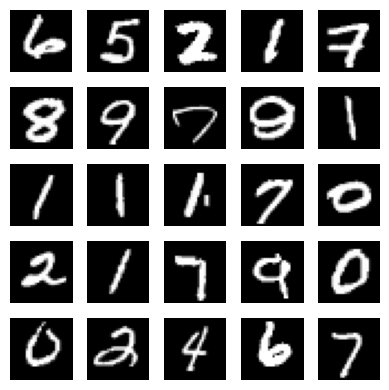

In [6]:
images, _ = next(iter(train_loader))

print(f"Ime zbirke:     MNIST")
print(f"Velikost učne množice:   {len(mnist_trainset)}")
print(f"Velikost testne množice:   {len(mnist_testset)}")
print(f"Dimenzija slik: {images[0].numpy().shape}")

_, axes = plt.subplots(5, 5, figsize=(4, 4), squeeze=False)
for i in range(5):
    for j in range(5):
        axes[i, j].imshow(images[5*i+j].numpy().transpose((1,2,0)), cmap="gray")
        axes[i, j].axis("off")
            
plt.tight_layout()

In [7]:
model = LeNet300(NUM_CHANNELS)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
loss_fn = torch.nn.CrossEntropyLoss()

print(torchinfo.summary(model, (BATCH_SIZE, 1, IMAGE_SIZE[1], IMAGE_SIZE[0])))

Layer (type:depth-idx)                   Output Shape              Param #
LeNet300                                 [128, 10]                 --
├─Linear: 1-1                            [128, 300]                235,500
├─ReLU: 1-2                              [128, 300]                --
├─Linear: 1-3                            [128, 100]                30,100
├─ReLU: 1-4                              [128, 100]                --
├─Linear: 1-5                            [128, 10]                 1,010
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
Total mult-adds (M): 34.13
Input size (MB): 0.40
Forward/backward pass size (MB): 0.42
Params size (MB): 1.07
Estimated Total Size (MB): 1.89


In [8]:
for i, data in enumerate(model.named_parameters()):
    name, param = data
    if "weight" in name:
        print(name)
        print(np.shape(param.data))

linear_1.weight
torch.Size([300, 784])
linear_2.weight
torch.Size([100, 300])
linear_3.weight
torch.Size([10, 100])


In [9]:
ip = IterativePruning(model)

ip.start(loss_fn, train_loader, val_loader, test_loader, LR, NUM_EPOCHS, 2, 0, 0.2)

 ===| Prune iteration 1/2 |=== 
Name                    Zeros Nonzeros      All Nonzeros(%)
linear_1.weight             0   235200   235200     100.00%
linear_1.bias               0      300      300     100.00%
linear_2.weight             0    30000    30000     100.00%
linear_2.bias               0      100      100     100.00%
linear_3.weight             0     1000     1000     100.00%
linear_3.bias               0       10       10     100.00%
all                         0   266610   266610     100.00%


Epoch: 6, loss: 0.0247, val_loss: 0.0849 Validating: : 79it [00:01, 41.44it/s]                       
Testing: 79it [00:03, 25.20it/s]                        


Accuracy: 0.979


 ===| Prune iteration 2/2 |=== 
Name                    Zeros Nonzeros      All Nonzeros(%)
linear_1.weight         47040   188160   235200      80.00%
linear_1.bias               0      300      300     100.00%
linear_2.weight          6000    24000    30000      80.00%
linear_2.bias               0      100      100     100.00%
linear_3.weight           100      900     1000      90.00%
linear_3.bias               0       10       10     100.00%
all                     53140   213470   266610      80.07%


Epoch: 6, loss: 0.0197, val_loss: 0.0852 Validating: : 79it [00:01, 42.96it/s]                       
Testing: 79it [00:02, 27.43it/s]                        

Accuracy: 0.981




In [10]:
print(type(ip.stats_tracker.iterations[0].epochs[0].val_loss))

<class 'float'>


In [11]:
#model = torch.load("model_lenet_mnist.pt")
#test(model, test_loader, len(mnist_testset))